# Import libraries

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output
import matplotlib.image as mpimg
from copy import deepcopy
%matplotlib inline

# Read data

In [4]:
cities = pd.read_csv('cities.csv')

# Calculate distance matrix

In [5]:
dist_mat = euclidean_distances(cities[["x",'y']])
dist_mat_df = pd.DataFrame(dist_mat)

In [6]:
dist_mat_df.head(15)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.000000,28.873300,82.129526,45.798532,68.350157,52.077630,72.078729,42.021184,51.016605,54.999851,28.729621,74.409471,22.710148,72.005344,45.462810
1,28.873300,0.000000,54.773225,45.658960,42.029454,43.217097,43.205582,22.769634,22.831269,30.618416,40.635151,51.106819,10.390598,51.904146,20.331958
2,82.129526,54.773225,0.000000,68.271066,45.678842,54.764850,22.758205,43.255511,40.721275,28.706295,79.494075,20.412598,64.537277,30.808909,51.039095
3,45.798532,45.658960,68.271066,0.000000,82.288911,14.401838,72.080483,30.516486,62.131194,42.025428,20.635150,50.958418,51.168335,42.911225,64.535357
4,68.350157,42.029454,45.678842,82.288911,0.000000,74.253893,22.920690,52.130340,20.358579,45.734147,82.084025,57.961693,45.640079,65.543104,22.887352
5,52.077630,43.217097,54.764850,14.401838,74.253893,0.000000,61.107538,22.702249,54.939798,30.515913,32.348203,36.731547,51.098494,28.510220,59.446348
6,72.078729,43.205582,22.758205,72.080483,22.920690,61.107538,0.000000,42.119403,22.763969,30.591751,77.534434,36.912330,51.081360,45.791797,32.374102
7,42.021184,22.769634,43.255511,30.516486,52.130340,22.702249,42.119403,0.000000,32.387302,14.549322,36.599190,32.444970,32.380180,30.525324,36.845823
8,51.016605,22.831269,40.721275,62.131194,20.358579,54.939798,22.763969,32.387302,0.000000,28.962861,61.952396,45.826845,28.982552,51.118842,10.318774
9,54.999851,30.618416,28.706295,42.025428,45.734147,30.515913,30.591751,14.549322,28.962861,0.000000,50.952978,20.488427,41.009011,22.760032,36.916192


# Genetic algorithm

In [12]:
class GeneticAlgorithm:
    def __init__(self, dist_mat, n_pop, n_gen, n_elite, swap_prop, mut_prop, tournment_k):
        self.dist_mat = dist_mat
        self.n_pop = n_pop
        self.n_gen = n_gen
        self.n_elite = n_elite
        self.swap_prop = swap_prop
        self.mut_prop = mut_prop
        self.tournment_k = tournment_k
        self.n_cities = dist_mat.shape[0]
        self.initial_pop = self.initialize_pop()  # Initialize the population
    
    def initialize_pop(self):
        initial_pop = np.array([np.array(range(0, self.n_cities)) for i in range(self.n_pop)])  # Create an array for the initial population
        for tour in initial_pop:
            np.random.shuffle(tour)  # Shuffle the cities to create random tours
        return initial_pop
    
    def calc_fitness(self, list_):
        cost = 0
        for i in range(len(list_) - 1):
            cost += self.dist_mat[list_[i], list_[i + 1]]  # Calculate the total distance of the tour by summing the distances between consecutive cities
        return 1 / cost  # Return the fitness as the inverse of the total distance
    
    def calc_pop_fitness(self, pop):
        pop_fit = []
        for i in range(pop.shape[0]):
            pop_fit.append(self.calc_fitness(pop[i]))  # Calculate the fitness for each tour in the population
        return np.array(pop_fit)
    
    def select_elites(self, pop, fit_scores):
        ind = np.argsort(-fit_scores)[:self.n_elite]  # Get the indices of the elite individuals (tours with highest fitness scores)
        return deepcopy(pop[ind])  # Return the elite individuals as a new population
    
    def tournament_selection(self, pop):
        parents = list(pop[np.random.choice(pop.shape[0], self.tournment_k, replace=False), :])  # Select a subset of individuals using tournament selection
        parents = sorted(parents, key=lambda parent: self.calc_fitness(parent), reverse=True)  # Sort the selected individuals based on their fitness scores
        return parents[0], parents[1]  # Return the two parents with the highest fitness scores
    
    def crossover(self, parent1, parent2):
        parent1_copy, parent2_copy = deepcopy(parent1), deepcopy(parent2)  # Create copies of the parents
        cutoff_1, cutoff_2 = np.sort(np.random.choice(np.arange(len(parent1)), size=2, replace=False))  # Randomly choose two points for crossover
        for i in range(cutoff_1, cutoff_2 + 1):
            try:
                parent1_copy[list(parent1_copy).index(parent2[i])] = parent1_copy[i]  # Swap the cities between the parents within the crossover points
            except:
                pass
            parent1_copy[i] = parent2[i]
        
        for i in range(cutoff_1, cutoff_2 + 1):
            try:
                parent2_copy[list(parent2_copy).index(parent1[i])] = parent2_copy[i]  # Swap the cities between the parents within the crossover points
            except:
                pass
            parent2_copy[i] = parent1[i]
        
        return parent1_copy, parent2_copy  # Return the two offspring
    
    def mutation(self, pop):
        pop_copy = deepcopy(pop)  # Create a copy of the population
        m, n = pop.shape
        for i in range(m):
            tour = np.random.choice(range(m))  # Randomly choose a tour for mutation
            if np.random.rand() < self.mut_prop:  # Perform mutation with a certain probability
                ind1, ind2 = np.random.choice(np.arange(n), size=2, replace=False)  # Randomly choose two cities for swapping
                pop_copy[tour, ind1], pop_copy[tour, ind2] = pop_copy[tour, ind2], pop_copy[tour, ind1]  # Swap the chosen cities
        return pop_copy  # Return the mutated population
    
    def plot_tour(self, tour, subtitle):
        clear_output(wait=True)
        tour = deepcopy(tour)
        n_cities = tour.shape[0]
        plt.rcParams["figure.figsize"] = [5, 5]
        X_values = deepcopy(cities["x"])
        Y_values = deepcopy(cities["y"])
        for i in range(n_cities):
            plt.text(X_values[i], Y_values[i], f"Point{i + 1}")  # Add labels for each city
        
        for i in range(n_cities - 1):
            city1, city2 = tour[i], tour[i + 1]
            point1 = [X_values[city1], Y_values[city1]]
            point2 = [X_values[city2], Y_values[city2]]
            x_values = [point1[0], point2[0]]
            y_values = [point1[1], point2[1]]
            plt.plot(x_values, y_values, 'bo', linestyle="--")  # Plot the connection between cities
        plt.axis('off')
        plt.grid()
        plt.title(f"Best tour at {subtitle}")
        plt.show()
        time.sleep(.2)
    
    def run_genetic_algorithm(self):
        old_gen = deepcopy(self.initial_pop)  # Create a copy of the initial population
        
        # calculate fitness scores
        fit_scores = self.calc_pop_fitness(old_gen)  # Calculate the fitness scores of the initial population
        
        # plot initial pop best tour
        best_tour = deepcopy(old_gen[np.argmax(fit_scores)])  # Get the best tour from the initial population
        self.plot_tour(best_tour, f"Initial Population, Fitness = ""{:.5f}".format(np.max(fit_scores)))  # Plot the best tour
        
        # loop over generations
        for gen in range(self.n_gen):
            # select elites
            elites = self.select_elites(old_gen, fit_scores)  # Select the elite individuals from the previous generation
            
            # calculate remaining population
            remain_crossover = (self.n_pop - self.n_elite) // 2  # Calculate the number of offspring needed
            remaining = []
            
            # loop over number of remaining crossovers
            for co in range(remain_crossover):
                
                # top k tournament selection
                parent1, parent2 = self.tournament_selection(old_gen)  # Select parents using tournament selection
                
                # swapping algorithm
                if np.random.rand() < self.swap_prop:  # Perform crossover or keep the parents
                    offspring1, offspring2 = self.crossover(parent1, parent2)  # Perform crossover between the parents
                    remaining.append(offspring1)
                    remaining.append(offspring2)
                else:
                    remaining.append(parent1)
                    remaining.append(parent2)
            
            # create new population
            new_gen = np.vstack((np.array(remaining), elites))  # Create the new population by combining offspring and elites
            
            # mutation
            new_gen = self.mutation(new_gen)  # Perform mutation on the new population
            
            # calculate fitness score of new generation
            fit_scores = self.calc_pop_fitness(new_gen)  # Calculate the fitness scores of the new generation
            old_gen = deepcopy(new_gen)  # Update the old generation with the new generation
            
            # find best tour in current population to draw
            if gen % 2 == 0:
                best_tour = deepcopy(new_gen[np.argmax(fit_scores)])  # Get the best tour from the current generation
                self.plot_tour(best_tour, f"Generation {gen + 1}, Fitness = ""{:.5f}".format(np.max(fit_scores)))  # Plot the best tour
        
        # calculate final fitness scores
        fit_scores = self.calc_pop_fitness(old_gen)  # Calculate the fitness scores of the final generation
        
        # find best tour
        best_tour = deepcopy(new_gen[np.argmax(fit_scores)])  # Get the best tour from the final generation
        
        # plot best tour
        self.plot_tour(best_tour, f"Final Generation, Fitness = ""{:.5f}".format(np.max(fit_scores)))  # Plot the best tour
        
        # print final results
        print("-" * 20)
        print(f"Final fitness after Generation {gen + 1} = {np.max(fit_scores)}")
        print("-" * 20)
        print(f"Final best tour = {best_tour + 1}")
        return best_tour  # Return the best tour obtained from the genetic algorithm


# Example

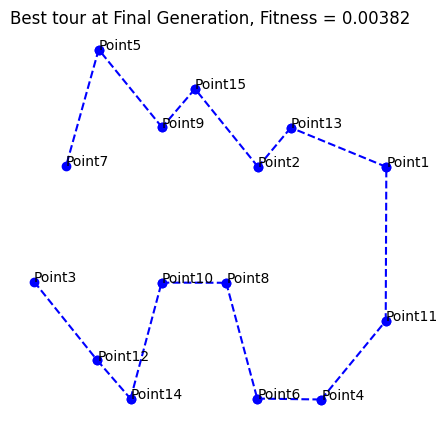

--------------------
Final fitness after Generation 50 = 0.0038222955871170345
--------------------
Final best tour = [ 3 12 14 10  8  6  4 11  1 13  2 15  9  5  7]


In [16]:
dist_mat
n_pop = 100
n_gen = 50
n_elite = 20
swap_prop = .7
mut_prop =.7
tournment_k = 10

ga = GeneticAlgorithm(dist_mat, n_pop, n_gen, n_elite, swap_prop, mut_prop, tournment_k)

best_tour = ga.run_genetic_algorithm()